In [1]:
import os

import torch
import torch.nn as nn
from torch.autograd import Variable, grad
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import torch.nn as nn
from PIL import Image
import numpy as np
import random
from tqdm import tqdm

import sys

import pickle
import argparse

import random, string

In [2]:
import os

machine_path = os.getcwd()
user_root_dir = '/'.join(machine_path.split('/')[:-2])
sys.path.insert(0,'%s/redner/'%user_root_dir)
import pyredner

In [3]:
print('PyRedner location: %s'%pyredner.__file__)

DATASET_NAME = "train_v6_shapenet"
MODEL_FILES_PICKLE_NAME = "categories_10_models_10.pkl"

SHAPENET_DIR = '%s/ShapeNetCore.v2'%user_root_dir

dataset_path = "%s/differentiable_graphics_ml/data/%s"%(user_root_dir, DATASET_NAME)
model_files_pickle_path = '%s/differentiable_graphics_ml/rendering/shapenet_model_subsets/%s'%(user_root_dir, MODEL_FILES_PICKLE_NAME)

if not os.path.isdir(dataset_path):
    print('This is a new dataset, creating a new folder at: %s'%dataset_path)
    os.mkdir(dataset_path)

PyRedner location: /net/storage001.ib.cluster/om2/user/smadan/redner/pyredner/__init__.py


In [4]:
def generate_uniform_on_sphere(num_points, radius):
    points = []
    for i in range(num_points):
        X = np.random.normal()
        Y = np.random.normal()
        Z = np.random.normal()

        vector = np.array([X,Y,Z])
        point = list(radius*vector/np.linalg.norm(vector))
        points.append(point)
    return points

def get_cam_position(radius_min, radius_max):
    cam_positions = []
    random_radius = random.uniform(radius_min, radius_max)
    cam_point = generate_uniform_on_sphere(1, random_radius)[0]
    cam_point = torch.tensor(cam_point).float()
    cam_positions.append(cam_point)
    
    return cam_positions

def get_positions(min_num_lights, max_num_lights, radius_min, radius_max):
    num_lights = random.choice(range(min_num_lights, max_num_lights + 1))
    light_positions = []
    
    for num in range(num_lights):
        random_radius = random.uniform(radius_min, radius_max)
        light_point = generate_uniform_on_sphere(1, random_radius)[0]
        light_point = torch.tensor(light_point).float()
        light_positions.append(light_point)
    
    return light_positions

def get_random_intensity():
    light_intensity = torch.tensor([random.uniform(0,1), \
                                    random.uniform(0,1), random.uniform(0,1)]).float()
    return light_intensity

def get_random_reflectance():
    specular_reflectance = torch.tensor([random.uniform(0,1), \
                                    random.uniform(0,1), random.uniform(0,1)], device = pyredner.get_device()).float()
    return specular_reflectance

def plane_object():
    mat = pyredner.Material(diffuse_reflectance = get_random_reflectance(), two_sided = True)
    
    plane = pyredner.Object(vertices = torch.tensor([[-1.0,-1.0, 1.0],
                                                 [-1.0, 1.0, 2.0],
                                                 [ 1.0,-1.0, 2.0],
                                                 [ 1.0, 1.0, 2.0]],
                                                 device = pyredner.get_device()),
                        indices = torch.tensor([[0, 1, 2],
                                                [1, 3, 2]],
                                               dtype = torch.int32,
                                               device = pyredner.get_device()),
                        uvs = torch.tensor([[0.05, 0.05],
                                            [0.05, 0.95],
                                            [0.95, 0.05],
                                            [0.95, 0.95]], device = pyredner.get_device()),
                        material = mat)
    return plane

In [5]:
def get_random_look_at(radius):
    K = 0.3
    look_at = torch.tensor([random.uniform(0,K*radius), random.uniform(0,K*radius), random.uniform(0,K*radius)]).float()
    return look_at

In [6]:
RADIUS_MIN = 1.0
RADIUS_MAX = 2.0 
MIN_NUM_LIGHTS = 3
MAX_NUM_LIGHTS = 4

RADIUS_MIN_CAM = 0.5
RADIUS_MAX_CAM = 1.5

In [7]:
def render_shapenet_obj(obj_path):
    all_light_positions = get_positions(MIN_NUM_LIGHTS, MAX_NUM_LIGHTS, RADIUS_MIN, RADIUS_MAX)
    camera_position = get_cam_position(RADIUS_MIN_CAM, RADIUS_MAX_CAM)[0]
    cam_radius = torch.sqrt(camera_position[0]**2 + camera_position[1]**2 + camera_position[2]**2).item()
    cam_look_at = get_random_look_at(cam_radius)
    obj_model_all = pyredner.load_obj(obj_path, return_objects=True)
    obj_model = [i for i in obj_model_all if len(i.vertices)>0]
    fov = torch.tensor([random.uniform(35,100)])
    cam_up = torch.tensor([random.uniform(-1,1), random.uniform(-1,1), random.uniform(-1,1)])
    
    m = pyredner.Material(diffuse_reflectance = torch.tensor([1.0, 1.0, 1.0], device='cuda:0'), \
                          two_sided = True)

    for part in obj_model:
        part.material = m

    scene_cam = pyredner.automatic_camera_placement(obj_model, resolution = (224, 224))
    scene_cam.position = camera_position
    scene_cam.look_at = cam_look_at
    scene_cam.fov = fov
    scene_cam.up = cam_up

    scene_lights = []
    light_intensities = []
    light_look_ats = []
    light_sizes = []
    
    for light_pos in all_light_positions:
        light_look_at = get_random_look_at(cam_radius)
        light_intensity = get_random_intensity()
        light_size = torch.tensor([random.uniform(0.1,5.0), random.uniform(0.1, 5.0)])
        
        scene_light = pyredner.generate_quad_light(position = light_pos,
                                         look_at = light_look_at,
                                         size = light_size,
                                         intensity = light_intensity,
                                         directly_visible = False)
        
        scene_lights.append(scene_light)
        
        light_look_ats.append(light_look_at)
        light_sizes.append(light_size)
        light_intensities.append(light_intensity)
    
    all_objects = obj_model + scene_lights
    scene = pyredner.Scene(objects = all_objects, camera = scene_cam)
    img = pyredner.render_pathtracing(scene,num_samples=512,seed=1)
    im = torch.pow(img.data, 1.0/2.2).cpu()
    im = im*255/torch.max(im)
    
    image = Image.fromarray(im.numpy().astype('uint8'))
    
    cat_key = model_file.split('/')[-4]
    inst_key = model_file.split('/')[-3]
    random_key = x = ''.join(random.choices(string.ascii_letters + string.digits, k=16))
    
    image_key = "%s_%s_%s"%(cat_key, inst_key, random_key)
    
    random_info = [all_light_positions, light_intensities, light_sizes, light_look_ats,
                   camera_position, cam_look_at, fov, cam_up]
    return image, image_key, random_info

In [8]:
model_files_pickle_path = '/om5/user/smadan/differentiable_graphics_ml/rendering/shapenet_model_subsets/%s'%MODEL_FILES_PICKLE_NAME
with open(model_files_pickle_path, 'rb') as F:
    model_files = pickle.load(F)

In [9]:
model_files.keys()

dict_keys(['02691156', '02818832', '02958343', '03001627', '03467517', '03624134', '03790512', '03928116', '03948459', '04256520', '04379243'])

/net/storage001.ib.cluster/om2/user/smadan/redner/pyredner/render_pytorch.py:214: UserWarning: Converting shape vertices from cpu to cuda:0, this can be inefficient.
  warnings.warn('Converting shape vertices from {} to {}, this can be inefficient.'.format(shape.vertices.device, device))
/net/storage001.ib.cluster/om2/user/smadan/redner/pyredner/render_pytorch.py:216: UserWarning: Converting shape indices from cpu to cuda:0, this can be inefficient.
  warnings.warn('Converting shape indices from {} to {}, this can be inefficient.'.format(shape.indices.device, device))
/net/storage001.ib.cluster/om2/user/smadan/redner/pyredner/render_pytorch.py:55: UserWarning: Converting texture from cpu to cuda:0, this can be inefficient.
  warnings.warn('Converting texture from {} to {}, this can be inefficient.'.format(mipmap.device, device))


Scene construction, time: 0.49694 s
Forward pass, time: 2.49363 s


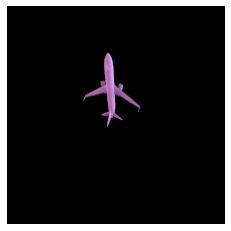

In [10]:
category = '02691156'

category_dir = "%s/%s"%(SHAPENET_DIR, category)
instance_model_files = model_files[category]
for i in range(1):
    for model_file in instance_model_files:
        model_file = model_file.replace('/om5/user/smadan',user_root_dir)
        instance = model_file.split('/')[-3]
        rendered_im, im_name, random_info = render_shapenet_obj(model_file)
        plt.imshow(rendered_im)
        plt.axis('off')
        plt.show()
        break